In [1]:
import math
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import nltk
from nltk import bigrams, trigrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from spellchecker import SpellChecker


from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

import lightgbm as lgb
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor

from sklearn.multioutput import RegressorChain
from sklearn.multioutput import MultiOutputRegressor

In [2]:
df = pd.read_csv("data/training_data/df_1.csv")

In [3]:
df.columns

Index(['prompt_id', 'prompt_question', 'prompt_title', 'prompt_text',
       'student_id', 'text', 'content', 'wording', 'len', 'ttr',
       'stopwords_ratio', 'cossim', 'conts', 'misspelled', 'nouns', 'adjs',
       'vbs', 'prons', 'nums', 'conjns'],
      dtype='object')

In [4]:
df = df.drop(['prompt_id', 'prompt_question', 'prompt_title', 'prompt_text',
       'student_id', 'text','nouns','adjs','vbs','prons','nums','conjns'], axis = 1)

In [5]:
df.head()

,content,wording,len,ttr,stopwords_ratio,cossim,conts,misspelled
0,-0.210614,-0.471415,59,0.593220,0.51,0.381895,0,0
1,-0.970237,-0.417058,30,0.933333,0.33,0.256620,0,2
2,-0.387791,-0.584181,74,0.689189,0.32,0.463205,1,1
3,0.088882,-0.594710,61,0.672131,0.44,0.547496,0,0
4,-0.687288,-0.460886,63,0.714286,0.44,0.517335,1,6


In [6]:
conts_n = []
mis_n = []

for i in df['conts']:
    if i == 0:
        conts_n.append(0)
    else:
        conts_n.append(np.sqrt(i))
        
for i in df['misspelled']:
    if i == 0:
        mis_n.append(0)
    else:
        mis_n.append(np.sqrt(i))

df['conts'],df['misspelled'] = conts_n,mis_n

In [7]:
df_test = df.loc[:, ['content','wording']]
df_train = df.drop(['content','wording'], axis = 1)

In [8]:
scale_cols = ['len']
df_train_sc = df_train[scale_cols]
scaler1 = StandardScaler()
sc_data = scaler1.fit_transform(df_train_sc)
df_train[scale_cols] = sc_data

In [9]:
df.shape

(2057, 8)

In [10]:
def split(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
    return x_train, x_test, y_train, y_test

xtrain, xtest, ytrain, ytest = split(df_train, df_test)

In [11]:
xtrain.shape

(1645, 6)

In [12]:
models = [RandomForestRegressor(), SVR(), LinearRegression()]

In [13]:
def training(x_train, y_train, x_test, y_test, m):
    chain = RegressorChain(m, order=[1, 0]).fit(x_train, y_train)
    pred = chain.predict(x_test)
    err = mean_squared_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    return err,r2

for model in models:
    print(training(xtrain, ytrain, xtest, ytest, model))

(0.36782052314569924, 0.6182090719726108)
(0.3467188186368151, 0.641606824305262)
(0.3977540711416196, 0.5858700286841938)


In [15]:
df.corr()

,content,wording,len,ttr,stopwords_ratio,cossim,conts,misspelled
content,1.000000,0.812911,0.817651,-0.715651,-0.031542,0.490107,0.304870,0.292871
wording,0.812911,1.000000,0.677444,-0.658177,-0.018613,0.344631,0.276212,0.255415
len,0.817651,0.677444,1.000000,-0.727686,-0.006908,0.543656,0.399486,0.348326
ttr,-0.715651,-0.658177,-0.727686,1.000000,-0.095234,-0.470718,-0.247143,-0.246262
stopwords_ratio,-0.031542,-0.018613,-0.006908,-0.095234,1.000000,0.192988,-0.003468,-0.041238
cossim,0.490107,0.344631,0.543656,-0.470718,0.192988,1.000000,0.139320,0.162969
conts,0.304870,0.276212,0.399486,-0.247143,-0.003468,0.139320,1.000000,0.135849
misspelled,0.292871,0.255415,0.348326,-0.246262,-0.041238,0.162969,0.135849,1.000000


In [17]:
df.sort_values(by = ['content','wording'])

,content,wording,len,ttr,stopwords_ratio,cossim,conts,misspelled
1038,-1.729859,-0.362702,33,0.818182,0.48,0.449405,0,1
2045,-1.729859,-0.362702,37,0.810811,0.30,0.465146,0,1
583,-1.638511,-0.911973,42,0.738095,0.55,0.348578,1,1
1184,-1.638511,-0.911973,31,0.967742,0.39,0.398580,0,2
1404,-1.638511,-0.911973,31,0.741935,0.42,0.448036,0,0
...,...,...,...,...,...,...,...,...
1887,3.503226,3.638126,353,0.354108,0.42,0.650360,1,3
673,3.626282,2.204294,337,0.433234,0.40,0.735464,1,4
216,3.802722,3.514831,313,0.495208,0.39,0.802367,0,2
402,3.834430,2.630271,357,0.422969,0.43,0.824505,6,4


C:\Users\asus_\AppData\Local\Temp\ipykernel_6220\3141914476.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['misspelled'],shade=True)


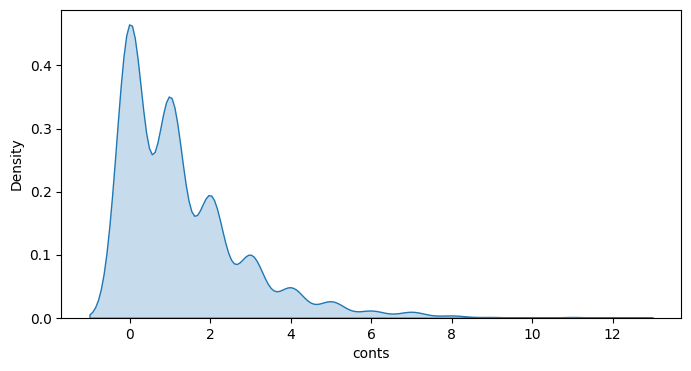

In [29]:
plt.figure(figsize=(8,4))
# plt.xlim(0,2000)
plt.xlabel('conts')
plt.ylabel('Density')
sns.kdeplot(df['misspelled'],shade=True)
plt.show()

In [44]:
dems = []
for i in df['conts']:
    if i == 0:
        dems.append(0)
    else:
        dems.append(np.sqrt(i))

C:\Users\asus_\AppData\Local\Temp\ipykernel_6220\2603602504.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(dems,shade=True)


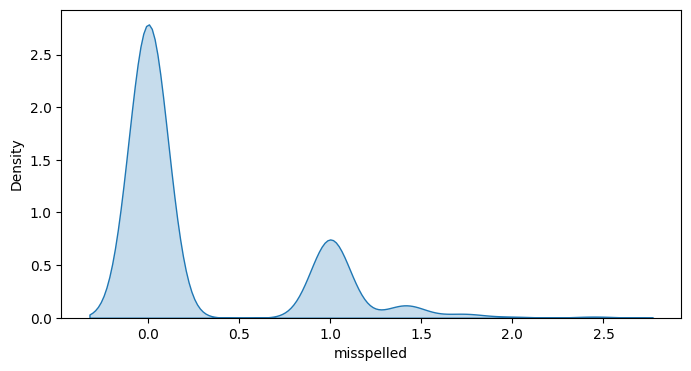

In [45]:
plt.figure(figsize=(8,4))
# plt.xlim(0,2000)
plt.xlabel('misspelled')
plt.ylabel('Density')
sns.kdeplot(dems,shade=True)
plt.show()

In [14]:
df['content']

0      -0.210614
1      -0.970237
2      -0.387791
3       0.088882
4      -0.687288
          ...   
2052   -0.981265
2053   -0.511077
2054   -0.834946
2055   -0.157460
2056   -0.393310
Name: content, Length: 2057, dtype: float64